In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [19]:
with open("output.json", "r") as f:
    data = json.load(f)
len(data)

1000

In [20]:
# Flatten data for DataFrame
flattened_data = []
for entry in data:
    flat = {
        "input_dim": entry["config"]["model"]["input_dim"],
        "output_dim": entry["config"]["model"]["output_dim"],
        "hidden_dim": entry["config"]["model"]["hidden_dim"],
        "num_layers": entry["config"]["model"]["num_layers"],
        "activation_fn_name":entry["config"]["model"]["activation_fn_name"],
        "batch_size": entry["config"]["batch_size"],
        "expect_param_count": entry["config"]["expect_param_count"],
        "time": entry["time"],
        "energy": entry["energy"]
    }
    flattened_data.append(flat)

df = pd.DataFrame(flattened_data)

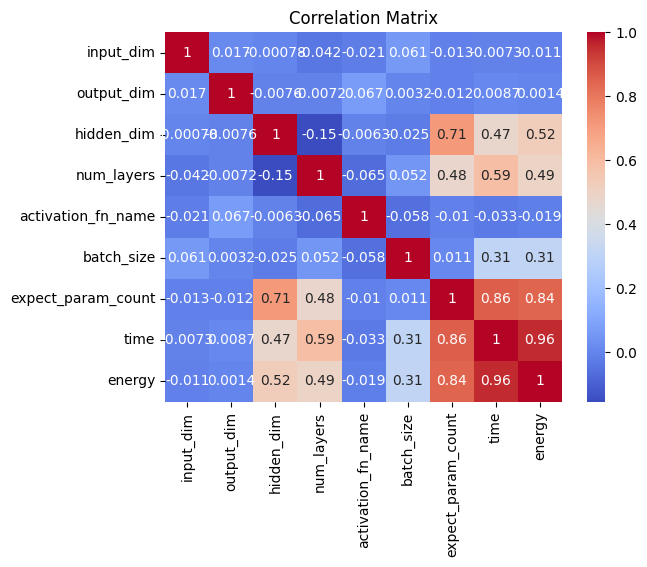

In [21]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

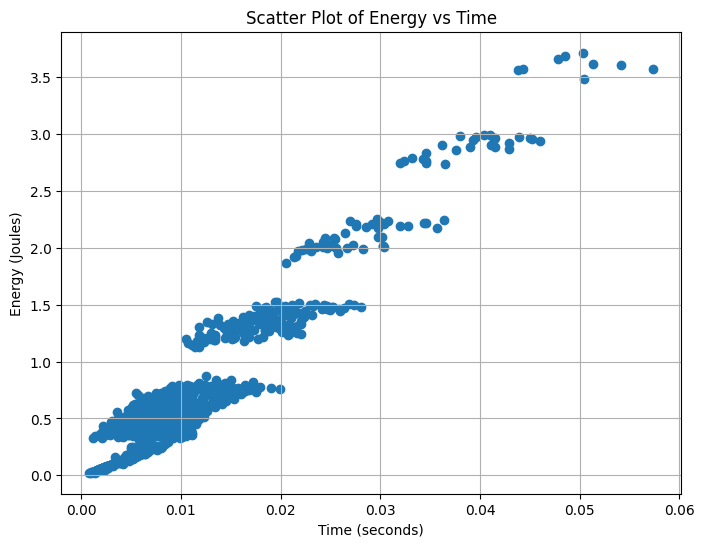

In [22]:
# Scatter plot of energy vs time
plt.figure(figsize=(8, 6))
plt.scatter(df["time"], df["energy"])
plt.xlabel("Time (seconds)")
plt.ylabel("Energy (Joules)")
plt.title("Scatter Plot of Energy vs Time")
plt.grid(True)
plt.show()


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Define features and targets
features = ["input_dim", "output_dim", "hidden_dim", "num_layers", "batch_size", "activation_fn_name"]
X = df[features]
y_time = df["time"]
y_energy = df["energy"]

# Split into training and testing sets
X_train, X_test, y_time_train, y_time_test, y_energy_train, y_energy_test = train_test_split(
    X, y_time, y_energy, test_size=0.2, random_state=42
)

# Fit models on training data
model_time = LinearRegression().fit(X_train, y_time_train)
model_energy = LinearRegression().fit(X_train, y_energy_train)

# Predict on test data
y_time_train_pred = model_time.predict(X_train)
y_energy_train_pred = model_energy.predict(X_train)
y_time_test_pred = model_time.predict(X_test)
y_energy_test_pred = model_energy.predict(X_test)

# Evaluate on test data
train_metrics = {
    "R2_time": r2_score(y_time_train, y_time_train_pred),
    "MSE_time": mean_squared_error(y_time_train, y_time_train_pred),
    "R2_energy": r2_score(y_energy_train, y_energy_train_pred),
    "MSE_energy": mean_squared_error(y_energy_train, y_energy_train_pred)
}

# Evaluation metrics on test set
test_metrics = {
    "R2_time": r2_score(y_time_test, y_time_test_pred),
    "MSE_time": mean_squared_error(y_time_test, y_time_test_pred),
    "R2_energy": r2_score(y_energy_test, y_energy_test_pred),
    "MSE_energy": mean_squared_error(y_energy_test, y_energy_test_pred)
}

test_metrics_df = pd.DataFrame([train_metrics, test_metrics])
test_metrics_df


,R2_time,MSE_time,R2_energy,MSE_energy
0,0.759778,0.000018,0.699257,0.131822
1,0.749679,0.000021,0.704814,0.146306


In [24]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('input', FloatTensorType([None, X_train.shape[1]]))]

# Convert to ONNX
onnx_model = convert_sklearn(model_time, initial_types=initial_type)
with open("L4_time.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

onnx_model = convert_sklearn(model_energy, initial_types=initial_type)
with open("L4_energy.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# Split data into training and test sets
X_train, X_test, y_time_train, y_time_test, y_energy_train, y_energy_test = train_test_split(
    X, y_time, y_energy, test_size=0.4, random_state=42
)

# Train Gradient Boosting models
gb_model_time = GradientBoostingRegressor().fit(X_train, y_time_train)
gb_model_energy = GradientBoostingRegressor().fit(X_train, y_energy_train)

# Predictions on test set
y_time_test_pred = gb_model_time.predict(X_test)
y_energy_test_pred = gb_model_energy.predict(X_test)
# Predictions on training set
y_time_train_pred = gb_model_time.predict(X_train)
y_energy_train_pred = gb_model_energy.predict(X_train)

# Evaluation metrics on training set
train_metrics = {
    "R2_time": r2_score(y_time_train, y_time_train_pred),
    "MSE_time": mean_squared_error(y_time_train, y_time_train_pred),
    "R2_energy": r2_score(y_energy_train, y_energy_train_pred),
    "MSE_energy": mean_squared_error(y_energy_train, y_energy_train_pred)
}

# Evaluation metrics on test set
test_metrics = {
    "R2_time": r2_score(y_time_test, y_time_test_pred),
    "MSE_time": mean_squared_error(y_time_test, y_time_test_pred),
    "R2_energy": r2_score(y_energy_test, y_energy_test_pred),
    "MSE_energy": mean_squared_error(y_energy_test, y_energy_test_pred)
}

test_metrics_df = pd.DataFrame([train_metrics, test_metrics])
test_metrics_df


,R2_time,MSE_time,R2_energy,MSE_energy
0,0.993621,5.155693e-07,0.967221,0.015068
1,0.976056,1.716562e-06,0.890462,0.047593
